In [20]:
import numpy as np
import pandas as pd
import itertools as it
import math
from scipy.linalg import lu
from scipy.linalg import lstsq
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import time
plt.style.use('seaborn-whitegrid')


# Gram-Schmidt

In [44]:
#Gera uma matriz LI
def matrizLI(m,n):
    A = np.random.randint(0,5,(m,n))
    p,l,u = lu(A)                         #Faz a decomposicao LU dela
    delj,deli = [],[]
    
    sup_indices = np.triu_indices(n)      #Retorna uma lista com os 'i's e outra lista com os 'j's da parte superior
    
    for i,j in zip(sup_indices[0],sup_indices[1]):
        if i!=j and u[i][j]==0:       #Percorre a parte superior da matriz U e checa aonde existe 0 
            deli.append(i)           #Lista as linhas onde existe o 0
            delj.append(j)           #Lista as colunas onde existe 0 pra deleta-las
               
    for i,j in it.product(deli,delj):
        A=np.delete(A,j,axis=1)           #Deleta as colunas listadas.
        e0=np.eye(m)[i]
        A=np.insert(A, j, e0, axis=1)     #Coloca o vetor ei(coluna i da identidade) no lugar do vetor que deixava LD
    
    return A



In [82]:
def gram_schmidt(A):
    # Criar matriz Q
    Q = np.zeros(A.shape)
    # Atualização dos vetores/colunas de    
    for i in range(A.shape[1]):
        # Vetor i de Q recebe o vetor i de A
        Q[:, i] = A[:, i]
        # Somatório das projeções dos vetores de A em Q
        for j in range(i):
            # formula para compor o q chapéu
            Q[:, i] -= Q[:, j].T @ A[:, i] * Q[:, j]
        # Normalização do vetor q
        #Q[:, i] /= np.linalg.norm(Q[:, i])
        # arredondamento, se divisao for muito pequena, aproximamos a 1, para reduzir erro numérico
        Q[:, i] /= np.linalg.norm(Q[:, i]) < 1e-8 and 1 or np.linalg.norm(Q[:, i])
        
    R = Q.T @ A
    return Q,R

Matriz A:
[[3 4 4 0 0]
 [4 1 2 1 4]
 [1 2 3 0 4]
 [3 1 0 0 2]
 [2 3 0 0 1]
 [3 1 4 0 0]
 [0 4 3 0 1]]

Matriz R:
[[ 6.9282e+00  4.3301e+00  5.0518e+00  5.7740e-01  4.0415e+00]
 [ 0.0000e+00  5.4083e+00  3.3513e+00 -2.7740e-01  6.4720e-01]
 [-0.0000e+00 -0.0000e+00  4.1531e+00  3.1000e-03  9.9800e-02]
 [-0.0000e+00 -0.0000e+00  0.0000e+00  7.6790e-01  2.4036e+00]
 [-0.0000e+00 -0.0000e+00 -0.0000e+00  0.0000e+00  3.9320e+00]]

Matriz Q:
[[ 0.433   0.3929  0.1194 -0.1841 -0.4002]
 [ 0.5774 -0.2774  0.0031  0.7679  0.    ]
 [ 0.1443  0.2542  0.3416 -0.0181  0.8295]
 [ 0.433  -0.1618 -0.3962 -0.3824  0.334 ]
 [ 0.2887  0.3236 -0.6123 -0.0977 -0.0204]
 [ 0.433  -0.1618  0.567  -0.3863 -0.1967]
 [ 0.      0.7396  0.1255  0.2666 -0.0336]]

Q x R:
[[ 3.e+00  4.e+00  4.e+00  0.e+00  0.e+00]
 [ 4.e+00  1.e+00  2.e+00  1.e+00  4.e+00]
 [ 1.e+00  2.e+00  3.e+00 -0.e+00  4.e+00]
 [ 3.e+00  1.e+00 -0.e+00  0.e+00  2.e+00]
 [ 2.e+00  3.e+00 -0.e+00 -0.e+00  1.e+00]
 [ 3.e+00  1.e+00  4.e+00  1.e-04  

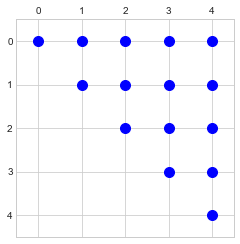

In [165]:
m, n = 7,5

A = matrizLI(m,n)
Q,R = gram_schmidt(A)
R = R.round(4)

print("Matriz A:\n{}\n\nMatriz R:\n{}\n\nMatriz Q:\n{}\n\nQ x R:\n{}".format(A, R, Q.round(4), (Q@R).round(4)))
print("\nMatriz A = Q x R??\n", (A.round(3)==(Q@R).round(3)))

plt.spy(R,marker='o',c='b')

# Rotação de Givens

In [84]:
def entradas(a,b):
    # Calcula seno e coseno para entradas da matriz de rotação.
    hip = math.hypot(a,b)
    cos = a/hip
    sen = -b/hip
    return (cos,sen)

In [85]:
def rotacao_givens(A):
    qtd_linhas, qtd_colunas = A.shape
                                   
    Q = np.identity(A.shape[0])             # Inicializando a matriz ortogonal Q.
    R = np.copy(A)                          # Inicializando a matriz triangular superior R.
    
    # As iterações serão feitas sobre a matriz triangular inferior
    linhas, colunas = np.tril_indices(qtd_linhas, -1, qtd_colunas)
    #i = 0
    for (linha, coluna) in zip(linhas, colunas):
        
        # As rotações são feitas para os valores da matriz triangular
        # inferior que são diferentes de zero.
        if(R[linha,coluna] != 0):
            cos, sen = entradas(R[coluna, coluna], R[linha,coluna])
            G = np.identity(qtd_linhas)
            G[coluna, coluna] = cos
            G[linha, linha] = cos
            G[linha, coluna] = sen
            G[coluna, linha] = -sen
            R = np.dot(G, R)
            Q = np.dot(Q,G.T)
        #i = i+1
        #print("Matriz Q{}:\n{}\n\nMatriz R{}:\n{}\n".format(i, Q.round(5), i, R.round(5)))
    return (Q,R)

Matriz A:
[[1 4 1 3 1]
 [1 1 3 3 2]
 [4 4 0 0 1]
 [4 4 4 2 3]
 [2 4 1 2 1]
 [1 2 2 2 3]
 [1 0 3 1 2]]

Matriz R:
[[ 6.32456e+00  7.43135e+00  4.26907e+00  3.32039e+00  4.11096e+00]
 [ 0.00000e+00  3.71147e+00 -1.95340e-01  2.78192e+00  3.90680e-01]
 [ 0.00000e+00  0.00000e+00  4.66228e+00  3.29633e+00  3.11571e+00]
 [-0.00000e+00 -0.00000e+00 -0.00000e+00  1.17052e+00 -6.21000e-03]
 [-0.00000e+00  0.00000e+00  0.00000e+00 -0.00000e+00  1.49655e+00]
 [ 0.00000e+00 -0.00000e+00 -0.00000e+00 -0.00000e+00 -0.00000e+00]
 [-0.00000e+00  0.00000e+00 -0.00000e+00 -0.00000e+00  0.00000e+00]]

Matriz Q:
[[ 0.1581  0.7612  0.1016  0.0193 -0.1763 -0.5546  0.2152]
 [ 0.1581 -0.0472  0.4967  0.8277 -0.1163  0.0812 -0.1444]
 [ 0.6325 -0.1886 -0.587   0.3073  0.2035 -0.142   0.2526]
 [ 0.6325 -0.1886  0.2709 -0.4002 -0.2492 -0.1556 -0.4946]
 [ 0.3162  0.4446 -0.0564 -0.086  -0.1994  0.7981  0.123 ]
 [ 0.1581  0.2223  0.2935 -0.0947  0.9008  0.0676 -0.1203]
 [ 0.1581 -0.3166  0.4854 -0.2088 -0.0268  0.

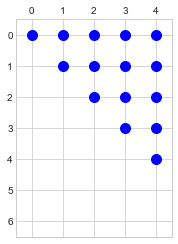

In [167]:
m, n = 7, 5
A = np.random.randint(0,5,(m,n))

Q, R = rotacao_givens(A)
R = R.round(5)

print("Matriz A:\n{}\n\nMatriz R:\n{}\n\nMatriz Q:\n{}\n\nInversa de Q:\n{}\n\nQ x R:\n{}".format(A, R, Q.round(4), np.linalg.inv(Q).round(4), (Q@R).round(4)))

print("\nMatriz A = Q x R??\n", (A.round(4)==(Q@R).round(4)))

plt.spy(R,marker='o',c='b')

# Householder

In [168]:
def matriz_householder(v):
    #Gera a matriz de refleccao para o vetor v
    tam_v = v.shape[0]
        
    e1 = np.eye(tam_v)[0]                        #Primeira coluna da identidade                    
    vetor = np.linalg.norm(v) * e1               #Vetor [||v||,0....]
    
    if v[0] < 0:                                 #Se o primeiro elemento for < 0,troca o sinal
        vetor = - vetor
    u = v + vetor
    
    H = np.eye(tam_v) -  ((2 * np.outer(u,u)) / np.dot(u,np.transpose(u)))      #Gera H
    
    return H

In [169]:
def QR_householder(A):
    m,n = A.shape                                 
    Q = np.eye(m)
    R = A
    menor_dim = min(m,n)

    for i in range(menor_dim):
        v = R[i:, i]                               #linha it pra frente e coluna it
        Hh = matriz_householder(v)                 #Recebe a matriz de refleccao para o vetor v

        H = np.eye(m)                              #Identidade
        H[i:, i:] = Hh                             #Preenche com a matriz de refleccao as linhas e colunas i pra frente

        R = np.dot(H, R)                           #Gera R
        Q = np.dot(Q, H)                           #Gera Q
        
    return Q,R

Matriz A:
[[2 4 3 0 2]
 [3 4 0 4 0]
 [4 3 1 4 4]
 [0 2 0 2 2]
 [2 2 4 1 2]
 [4 4 4 4 2]
 [1 3 0 4 0]]

Matriz R:
[[-7.07107e+00 -7.77817e+00 -4.80833e+00 -7.07107e+00 -4.52548e+00]
 [ 0.00000e+00 -3.67423e+00 -4.35460e-01 -1.90516e+00 -2.17730e-01]
 [-0.00000e+00  0.00000e+00  4.32324e+00 -2.50498e+00  9.58820e-01]
 [-0.00000e+00 -0.00000e+00 -0.00000e+00 -3.01586e+00  4.31000e-03]
 [ 0.00000e+00  0.00000e+00  0.00000e+00 -0.00000e+00  3.24858e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00 -0.00000e+00 -0.00000e+00]
 [ 0.00000e+00  0.00000e+00 -0.00000e+00 -0.00000e+00 -0.00000e+00]]

Matriz Q:
[[-0.2828 -0.4899  0.33    0.6985  0.0905  0.0831  0.2609]
 [-0.4243 -0.1905 -0.4911  0.1966 -0.4591 -0.2264 -0.4918]
 [-0.5657  0.381  -0.3595  0.0579  0.5748 -0.1185  0.2404]
 [ 0.     -0.5443 -0.0548 -0.2738  0.5957  0.1865 -0.4859]
 [-0.2828  0.0544  0.6161 -0.2146  0.0437 -0.6667 -0.212 ]
 [-0.5657  0.1089  0.307  -0.3238 -0.2553  0.634  -0.0438]
 [-0.1414 -0.5171 -0.2094 -0.4942 -0.1692 -0.

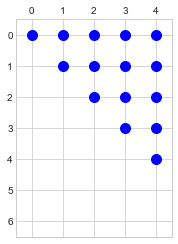

In [170]:
m,n = 7,5
A = np.random.randint(0,5,(m,n))

Q,R = QR_householder(A)

R = R.round(5)

print("Matriz A:\n{}\n\nMatriz R:\n{}\n\nMatriz Q:\n{}\n\nInversa de Q:\n{}\n\nQ x R:\n{}".format(A, R, Q.round(4), np.linalg.inv(Q).round(4), (Q@R).round(4)))
print("\nMatriz A = Q x R??\n", (A.round(4)==(Q@R).round(4)))

plt.spy(R,marker='o',c='b')

# Gráficos

In [173]:
def rodar(f,dim):
    #f: Método a ser rodado
    #dim: lista com as dimensoes das matrizes
    
    tempos = []
    temposGeracao = []
    flag = False
    
    if f.__name__ == 'gram_schmidt': flag = True
        
    for i in dim:
        tempo = []
        print("Dimensão: {}".format(i))
        if flag:
            t0g = time.time()
            A = matrizLI(i,i)
            tfg = time.time()
            temposGeracao.append(tfg-t0g)
        else:
            A = np.random.randint(0,5,(i,i))
        for _ in range(3):
            t0 = time.time()
            f(A)
            tf = time.time()
            tempo.append(tf-t0)
        tempos.append(tempo)
        
    tempos = [np.mean(i) for i in tempos]
    #print('Tempos de Geracao da matriz LI=',temposGeracao)
    return tempos

In [46]:
def plotar(holder, schmidt, givens, dim,log=None):
    #dim: lista com as dimensoes das matrizes
    
    plt.figure(figsize=(14,12))
    plt.title('Decomposição QR',size='x-large')
    plt.xlabel('Dimensões',size='x-large')
    plt.ylabel('Segundos',size='x-large')
    if log:
        plt.yscale('log')
        plt.xscale('log')
    plt.plot(dim,holder,marker='v',ms=13.0,label='Householder')
    plt.plot(dim,schmidt,marker='^',ms=13.0,label='Gram-Schmidt')
    plt.plot(dim,givens,marker='o',ms=13.0,label='Givens')
    plt.legend(title='Método:',title_fontsize='xx-large',fontsize='x-large')
    plt.show()
    

### Só rode essa celula abaixo se quiser esperar muito tempo

In [4]:
dim = [50, 70, 100, 150, 200, 300]
temposHolder = rodar(QR_householder,dim)
temposSchmidt = rodar(gram_schmidt,dim)
temposGivens = rodar(rotacao_givens,dim)

In [176]:
temposHolder

[0.005318959554036458,
 0.006981054941813151,
 0.012311776479085287,
 0.040215253829956055,
 0.08510629336039226,
 0.40923913319905597]

In [177]:
temposSchmidt

[0.008976221084594727,
 0.019946575164794922,
 0.03757794698079427,
 0.0890950361887614,
 0.15392168362935385,
 0.3726704915364583]

In [178]:
temposGivens

[0.03224714597066244,
 0.09640900293986003,
 0.3370986779530843,
 2.012287219365438,
 7.407861550649007,
 50.75064746538798]

### Rode essa célula abaixo pra pegar os tempos já prontos

In [7]:
temposHolder= [0.005318959554036458,0.006981054941813151,0.012311776479085287,0.040215253829956055,0.08510629336039226,0.40923913319905597]
temposSchmidt = [0.008976221084594727,0.019946575164794922,0.03757794698079427,0.0890950361887614,0.15392168362935385,0.3726704915364583]
temposGivens = [0.03224714597066244,0.09640900293986003,0.3370986779530843,2.012287219365438,7.407861550649007,50.75064746538798]

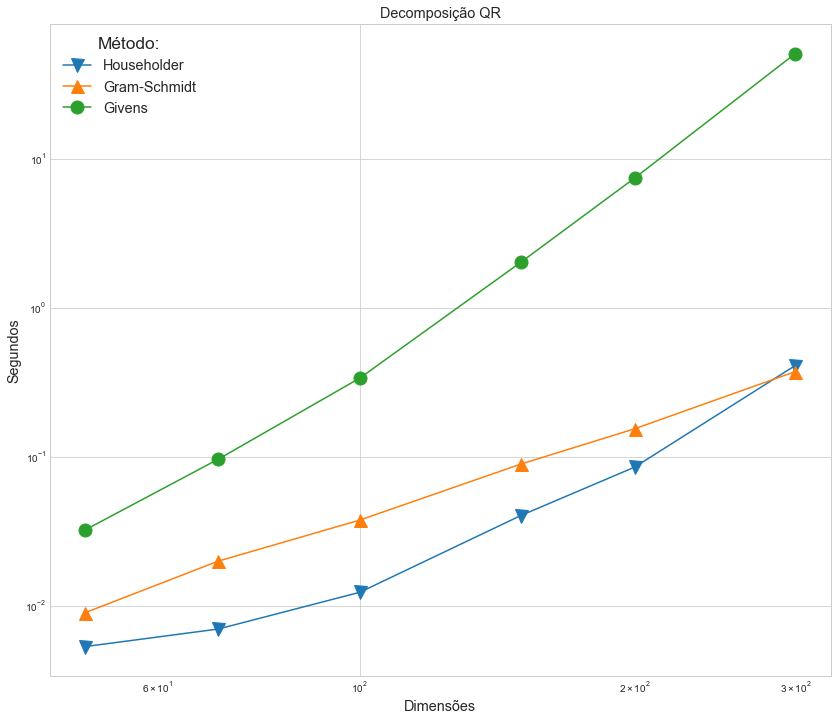

In [43]:
plotar(temposHolder,temposSchmidt,temposGivens,dim,True)

# Regressão Gram-Schmidt

### REGRESSÃO SEM LOG-SCALE 

In [9]:
x = np.array(dim)
A = x[:, np.newaxis]**[0,1]               #Criou uma nova coluna só de 1
A

array([[  1,  50],
       [  1,  70],
       [  1, 100],
       [  1, 150],
       [  1, 200],
       [  1, 300]], dtype=int32)

In [10]:
#Achar y = a*x+b
y = np.array(temposSchmidt)
p, res, rnk, s = lstsq(A,y)
p

array([-0.09389346,  0.00143167])

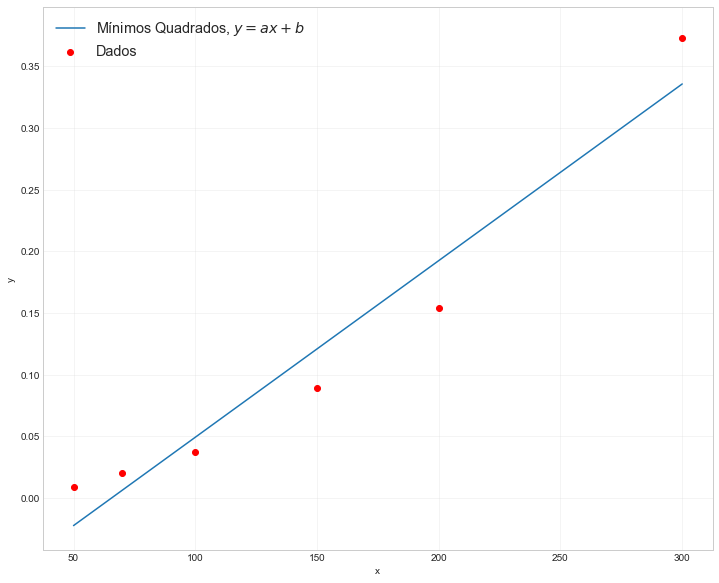

In [13]:
plt.figure(figsize=(12,10))
plt.scatter(x,y,marker= 'o', label='Dados',color='r')

yy = p[0] + (p[1]*x)
plt.plot(x, yy, label='Mínimos Quadrados, $y = ax + b$')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(framealpha=1, shadow=True,fontsize='x-large')
plt.grid(alpha=0.25)
plt.show()

### REGRESSÃO COM LOG-SCALE

In [15]:
logX = np.log(x)
logY = np.log(y)

In [16]:
logA = logX[:, np.newaxis]**[0,1]               #Criou uma nova coluna só de 1
logA

array([[1.        , 3.91202301],
       [1.        , 4.24849524],
       [1.        , 4.60517019],
       [1.        , 5.01063529],
       [1.        , 5.29831737],
       [1.        , 5.70378247]])

In [17]:
p, res, rnk, s = lstsq(logA,logY)
p

array([-12.68756462,   2.04805353])

In [18]:
res

0.008841601760461656

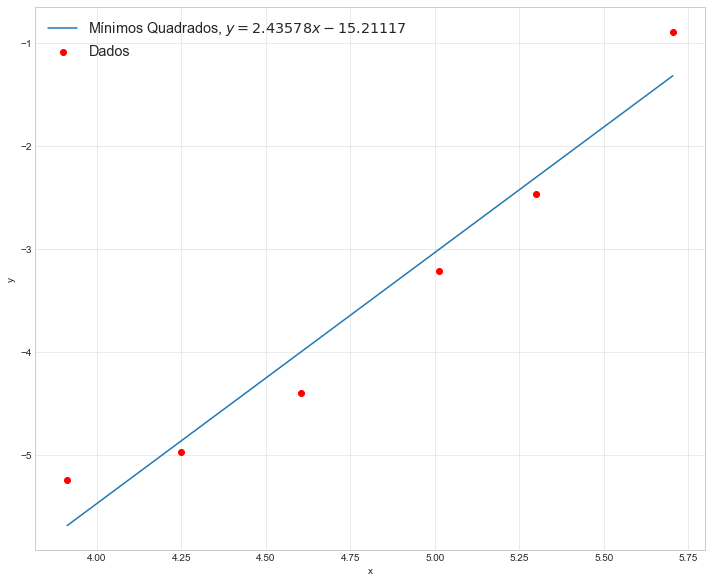

In [41]:
plt.figure(figsize=(12,10))
plt.scatter(logX,logY,marker= 'o', label='Dados',color='r')

yy = p[0] + (p[1]*logX)
plt.plot(logX, yy, label='Mínimos Quadrados, $y = {}x {}$'.format(np.round(p[1],5),np.round(p[0],5)))
plt.xlabel('x')
plt.ylabel('y')
plt.legend(framealpha=0.5, shadow=False,fontsize='x-large')
plt.grid(alpha=0.5)
plt.show()

### Erro quadrático médio - Gram-Schmidt

In [22]:
mean_squared_error(logY,yy)

0.0014736002934101608

# Regressão Rotação de Givens

### REGRESSÃO SEM LOG-SCALE 

In [23]:
x = np.array(dim)
A = x[:, np.newaxis]**[0,1]               #Criou uma nova coluna só de 1
A

array([[  1,  50],
       [  1,  70],
       [  1, 100],
       [  1, 150],
       [  1, 200],
       [  1, 300]], dtype=int32)

In [24]:
#Achar y = a*x+b
y = np.array(temposGivens)
p, res, rnk, s = lstsq(A,y)
p

array([-17.26454095,   0.18876298])

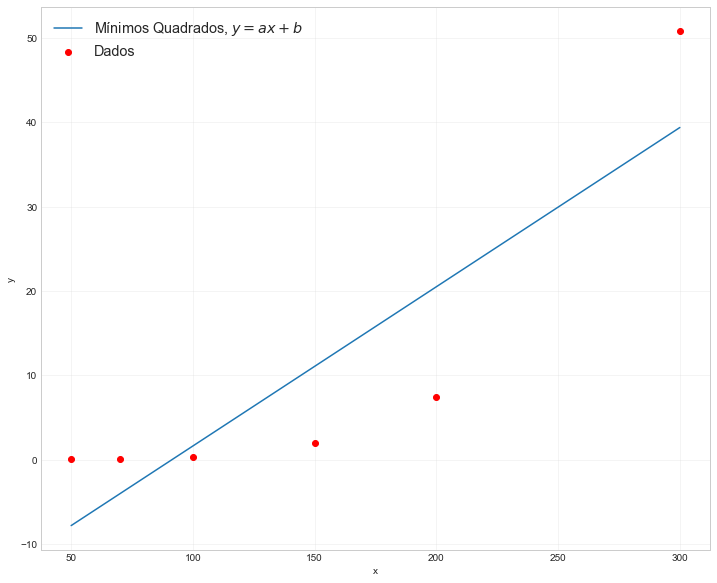

In [25]:
plt.figure(figsize=(12,10))
plt.scatter(x,y,marker= 'o', label='Dados',color='r')

yy = p[0] + (p[1]*x)
plt.plot(x, yy, label='Mínimos Quadrados, $y = ax + b$')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(framealpha=1, shadow=True,fontsize='x-large')
plt.grid(alpha=0.25)
plt.show()

### REGRESSÃO COM LOG-SCALE

In [26]:
logX = np.log(x)
logY = np.log(y)

In [27]:
logA = logX[:, np.newaxis]**[0,1]               #Criou uma nova coluna só de 1
logA

array([[1.        , 3.91202301],
       [1.        , 4.24849524],
       [1.        , 4.60517019],
       [1.        , 5.01063529],
       [1.        , 5.29831737],
       [1.        , 5.70378247]])

In [28]:
p, res, rnk, s = lstsq(logA,logY)
p

array([-19.83400491,   4.1271165 ])

In [29]:
res

0.20454006430408084

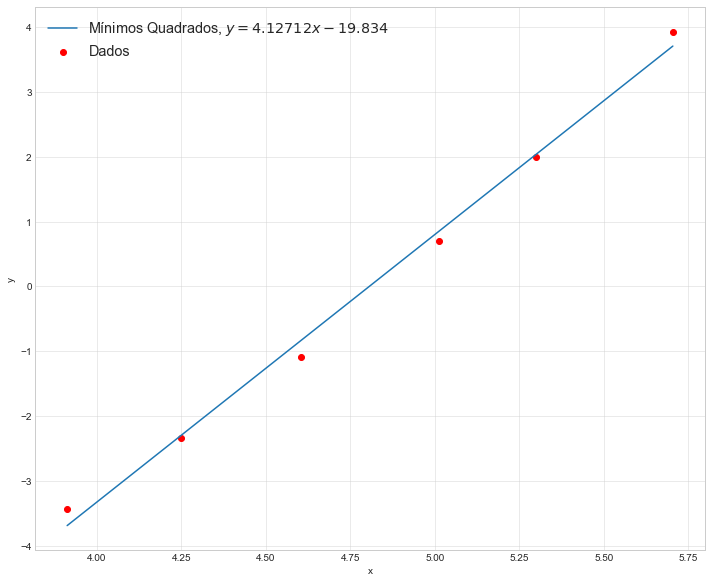

In [30]:
plt.figure(figsize=(12,10))
plt.scatter(logX,logY,marker= 'o', label='Dados',color='r')

yy = p[0] + (p[1]*logX)
plt.plot(logX, yy, label='Mínimos Quadrados, $y = {}x {}$'.format(np.round(p[1],5),np.round(p[0],5)))
plt.xlabel('x')
plt.ylabel('y')
plt.legend(framealpha=0.5, shadow=False,fontsize='x-large')
plt.grid(alpha=0.5)
plt.show()

### Erro quadrático médio - Givens

In [32]:
mean_squared_error(logY,yy)

0.03409001071734822

# Regressão Householder

### REGRESSÃO SEM LOG-SCALE 

In [33]:
x = np.array(dim)
A = x[:, np.newaxis]**[0,1]               #Criou uma nova coluna só de 1
A

array([[  1,  50],
       [  1,  70],
       [  1, 100],
       [  1, 150],
       [  1, 200],
       [  1, 300]], dtype=int32)

In [34]:
#Achar y = a*x+b
y = np.array(temposHolder)
p, res, rnk, s = lstsq(A,y)
p

array([-0.12797045,  0.00152528])

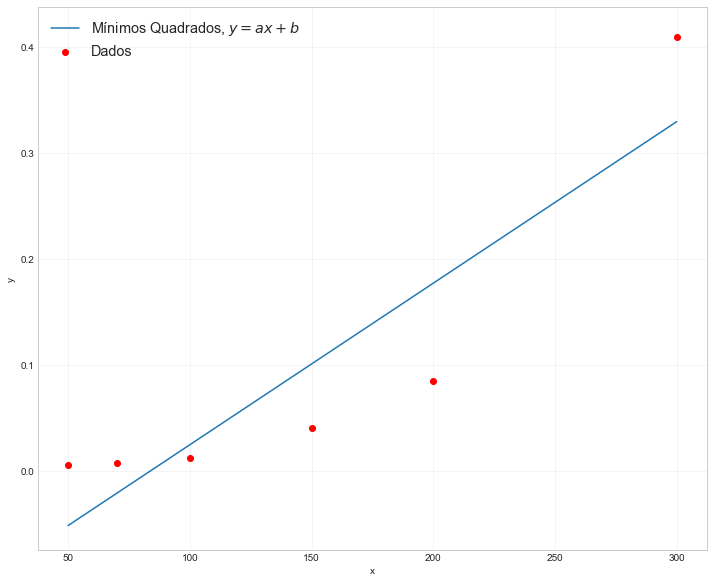

In [35]:
plt.figure(figsize=(12,10))
plt.scatter(x,y,marker= 'o', label='Dados',color='r')

yy = p[0] + (p[1]*x)
plt.plot(x, yy, label='Mínimos Quadrados, $y = ax + b$')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(framealpha=1, shadow=True,fontsize='x-large')
plt.grid(alpha=0.25)
plt.show()

### REGRESSÃO COM LOG-SCALE

In [36]:
logX = np.log(x)
logY = np.log(y)

In [37]:
logA = logX[:, np.newaxis]**[0,1]               #Criou uma nova coluna só de 1
logA

array([[1.        , 3.91202301],
       [1.        , 4.24849524],
       [1.        , 4.60517019],
       [1.        , 5.01063529],
       [1.        , 5.29831737],
       [1.        , 5.70378247]])

In [38]:
p, res, rnk, s = lstsq(logA,logY)
p

array([-15.21116968,   2.43578205])

In [39]:
res

0.6199237280936534

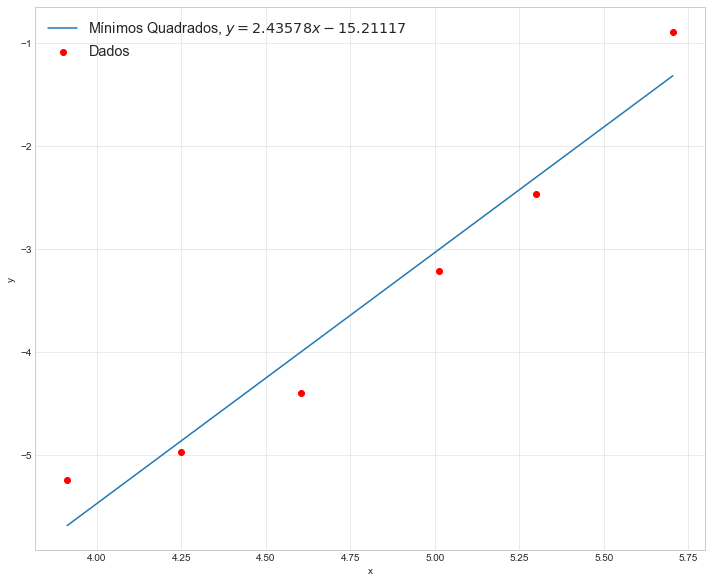

In [40]:
plt.figure(figsize=(12,10))
plt.scatter(logX,logY,marker= 'o', label='Dados',color='r')

yy = p[0] + (p[1]*logX)
plt.plot(logX, yy, label='Mínimos Quadrados, $y = {}x {}$'.format(np.round(p[1],5),np.round(p[0],5)))
plt.xlabel('x')
plt.ylabel('y')
plt.legend(framealpha=0.5, shadow=False,fontsize='x-large')
plt.grid(alpha=0.5)
plt.show()

### Erro quadrático médio - Householder

In [42]:
mean_squared_error(logY,yy)

0.10332062134894386